# Setup


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import statistics
import random
import time
import math
import numpy as np
import cv2
import copy
import shutil
import os
import json

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2020FA folder and put all the files under A5 folder, then '2020FA/A5'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'FasterRCNN'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['RPNSolver.py', 'FasterRCNN.py', 'FasterRCNN.ipynb', 'dataset.py', '__pycache__', 'VOCtrainval_06-Nov-2007.tar', 'VOCdevkit', 'extracted.txt']


In [5]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()


FasterRCNN_path = os.path.join(GOOGLE_DRIVE_PATH, 'FasterRCNN.py')
FasterRCNN_edit_time = time.ctime(os.path.getmtime(FasterRCNN_path))
dataset_path = os.path.join(GOOGLE_DRIVE_PATH, 'dataset.py')
dataset_edit_time = time.ctime(os.path.getmtime(dataset_path))
RPNSolver_path = os.path.join(GOOGLE_DRIVE_PATH, 'RPNSolver.py')
RPNSolver_edit_time = time.ctime(os.path.getmtime(RPNSolver_path))

In [6]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

from RPNSolver import *
from FasterRCNN import *
from dataset import *

In [7]:
!rm -rf mAP
!git clone https://github.com/Cartucho/mAP.git
!rm -rf mAP/input/*

Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 7.42 MiB/s, done.
Resolving deltas: 100% (321/321), done.


In [9]:
train_dataset = get_pascal_voc2007_data(GOOGLE_DRIVE_PATH, 'train')
val_dataset = get_pascal_voc2007_data(GOOGLE_DRIVE_PATH, 'val')

train_dataset = torch.utils.data.Subset(train_dataset, torch.arange(0, 2500)) # use 2500 samples for training
train_loader = pascal_voc2007_loader(train_dataset, 10)
val_loader = pascal_voc2007_loader(val_dataset, 10)

In [10]:
train_loader_iter = iter(train_loader)
img, ann, _, _, _ = train_loader_iter.next()

print('Resized train images shape: ', img[0].shape)
print('Padded annotation tensor shape: ', ann[0].shape)
print(ann[0])
print('Each row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).')
print('Padded with bounding boxes (-1, -1, -1, -1, -1) to enable batch loading. (You may need to run a few times to see the paddings)')

Resized train images shape:  torch.Size([3, 224, 224])
Padded annotation tensor shape:  torch.Size([6, 5])
tensor([[156.,  97., 351., 270.,   6.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.]])
Each row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).
Padded with bounding boxes (-1, -1, -1, -1, -1) to enable batch loading. (You may need to run a few times to see the paddings)


In [26]:
# default examples for visualization
random.seed(0)
torch.manual_seed(0)
batch_size = 3
sampled_idx = torch.linspace(0, len(train_dataset)-1, steps=batch_size).long()

# get the size of each image first
h_list = []
w_list = []
img_list = [] # list of images
MAX_NUM_BBOX = 40
box_list = torch.LongTensor(batch_size, MAX_NUM_BBOX, 5).fill_(-1) # PADDED GT boxes

for idx, i in enumerate(sampled_idx):
  # hack to get the original image so we don't have to load from local again...
  img, ann = train_dataset.__getitem__(i)
  img_list.append(img)

  all_bbox = ann['annotation']['object']
  if type(all_bbox) == dict:
    all_bbox = [all_bbox]
  for bbox_idx, one_bbox in enumerate(all_bbox):
    bbox = one_bbox['bndbox']
    obj_cls = one_bbox['name']
    box_list[idx][bbox_idx] = torch.LongTensor([int(bbox['xmin']), int(bbox['ymin']),
      int(bbox['xmax']), int(bbox['ymax']), class_to_idx[obj_cls]])

  # get sizes
  img = np.array(img)
  w_list.append(img.shape[1])
  h_list.append(img.shape[0])

w_list = torch.tensor(w_list, dtype=torch.float32, device='cuda')
h_list = torch.tensor(h_list, dtype=torch.float32, device='cuda')
box_list = torch.tensor(box_list, dtype=torch.float32, device='cuda')
resized_box_list = coord_trans(box_list, w_list, h_list, mode='p2a')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [27]:
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
batch_size = 3
sampled_idx = torch.linspace(0, len(train_dataset)-1, steps=batch_size).long()

# get the size of each image first
h_list = []
w_list = []
img_list = [] # list of images
MAX_NUM_BBOX = 40
box_list = torch.LongTensor(batch_size, MAX_NUM_BBOX, 5).fill_(-1) # PADDED GT boxes

for idx, i in enumerate(sampled_idx):
  # hack to get the original image so we don't have to load from local again...
  img, ann = train_dataset.__getitem__(i)
  img_list.append(img)

  all_bbox = ann['annotation']['object']
  if type(all_bbox) == dict:
    all_bbox = [all_bbox]
  for bbox_idx, one_bbox in enumerate(all_bbox):
    bbox = one_bbox['bndbox']
    obj_cls = one_bbox['name']
    box_list[idx][bbox_idx] = torch.LongTensor([int(bbox['xmin']), int(bbox['ymin']),
      int(bbox['xmax']), int(bbox['ymax']), class_to_idx[obj_cls]])

  # get sizes
  img = np.array(img)
  w_list.append(img.shape[1])
  h_list.append(img.shape[0])

w_list = torch.as_tensor(w_list, **to_float_cuda)
h_list = torch.as_tensor(h_list, **to_float_cuda)
box_list = torch.as_tensor(box_list, **to_float_cuda)
resized_box_list = coord_trans(box_list, w_list, h_list, mode='p2a') # on activation map coordinate system

car


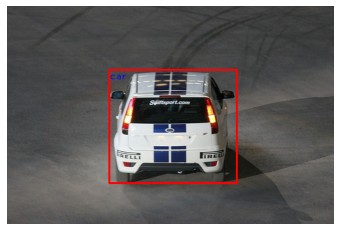

cat
tvmonitor


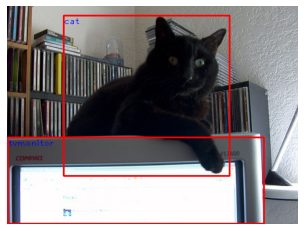

car


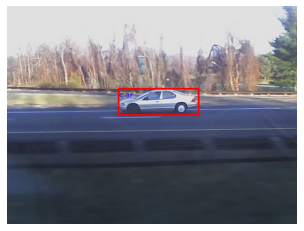

In [28]:
for i in range(len(img_list)):
  valid_box = sum([1 if j != -1 else 0 for j in box_list[i][:, 0]])
  detection_visualizer(img_list[i], idx_to_class, box_list[i][:valid_box])

# Backbone Network -> MobileNet v2

In [11]:
model = FeatureExtractor(verbose=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

# RPN

In [12]:
anchor_list = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [2, 3], [3, 2], [3, 5], [5, 3]], 
                           dtype=torch.float32, device='cuda')

number of pos proposals :  8
********************************************************************************
Activated (positive) anchors:
1 activated anchors!


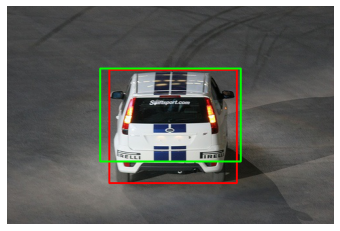

5 activated anchors!


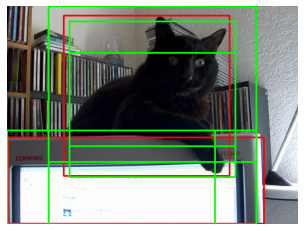

2 activated anchors!


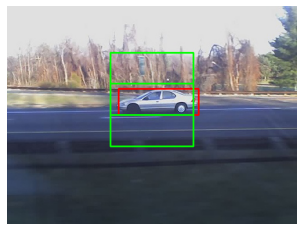

********************************************************************************
Negative anchors:
3 negative anchors!


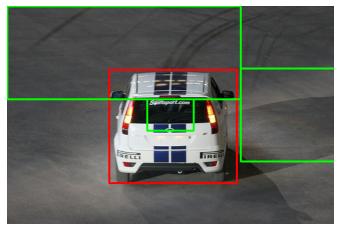

2 negative anchors!


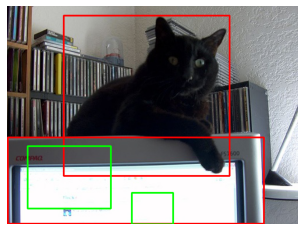

3 negative anchors!


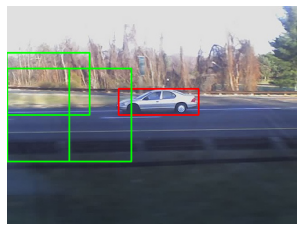

In [29]:
grid_list = GenerateGrid(w_list.shape[0])
anc_list = GenerateAnchor(anchor_list, grid_list)
iou_mat = IoU(anc_list, resized_box_list)
activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, \
  activated_anc_coord, negative_anc_coord = ReferenceOnActivatiedAnchors(anc_list, resized_box_list, grid_list, iou_mat)

# visualize the activated anchors
anc_per_img = torch.prod(torch.tensor(anc_list.shape[1:-1]))

print('*'*80)
print('Activated (positive) anchors:')
for img, bbox, idx in zip(img_list, box_list, torch.arange(box_list.shape[0])):
  anc_ind_in_img = (activated_anc_ind >= idx * anc_per_img) & (activated_anc_ind < (idx+1) * anc_per_img)
  print('{} activated anchors!'.format(torch.sum(anc_ind_in_img)))
  data_visualizer(img, idx_to_class, bbox[:, :4], coord_trans(activated_anc_coord[anc_ind_in_img], w_list[idx], h_list[idx]))

print('*'*80)
print('Negative anchors:')
for img, bbox, idx in zip(img_list, box_list, torch.arange(box_list.shape[0])):
  anc_ind_in_img = (negative_anc_ind >= idx * anc_per_img) & (negative_anc_ind < (idx+1) * anc_per_img)
  print('{} negative anchors!'.format(torch.sum(anc_ind_in_img)))
  data_visualizer(img, idx_to_class, bbox[:, :4], coord_trans(negative_anc_coord[anc_ind_in_img], w_list[idx], h_list[idx]))

lr:  0.001
number of pos proposals :  50
(Iter 0 / 1)
(Epoch 0 / 200) loss: 32.9704 time per epoch: 0.2s
number of pos proposals :  50
(Iter 0 / 1)
(Epoch 1 / 200) loss: 109.9656 time per epoch: 0.2s
number of pos proposals :  50
(Iter 0 / 1)
(Epoch 2 / 200) loss: 32.5366 time per epoch: 0.2s
number of pos proposals :  50
(Iter 0 / 1)
(Epoch 3 / 200) loss: 22.0366 time per epoch: 0.2s
number of pos proposals :  50
(Iter 0 / 1)
(Epoch 4 / 200) loss: 19.5600 time per epoch: 0.2s
number of pos proposals :  50
(Iter 0 / 1)
(Epoch 5 / 200) loss: 18.4286 time per epoch: 0.1s
number of pos proposals :  50
(Iter 0 / 1)
(Epoch 6 / 200) loss: 17.6401 time per epoch: 0.1s
number of pos proposals :  50
(Iter 0 / 1)
(Epoch 7 / 200) loss: 17.0446 time per epoch: 0.1s
number of pos proposals :  50
(Iter 0 / 1)
(Epoch 8 / 200) loss: 16.5729 time per epoch: 0.1s
number of pos proposals :  50
(Iter 0 / 1)
(Epoch 9 / 200) loss: 15.1265 time per epoch: 0.1s
number of pos proposals :  50
(Iter 0 / 1)
(Epoc

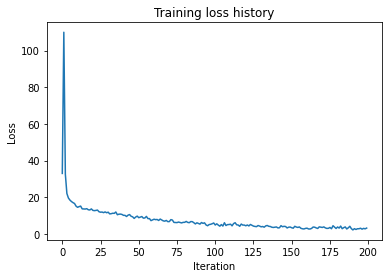

In [13]:
RPNSolver = DetectionSolver

num_sample = 10
small_dataset = torch.utils.data.Subset(train_dataset, torch.linspace(0, len(train_dataset)-1, steps=num_sample).long())
small_train_loader = pascal_voc2007_loader(small_dataset, 10) # a new loader

for lr in [1e-3]:
  print('lr: ', lr)
  rpn = RPN()
  RPNSolver(rpn, small_train_loader, learning_rate=lr, num_epochs=200)

In [14]:
RPNInference = DetectionInference

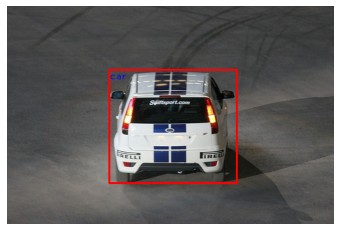

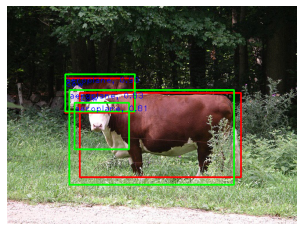

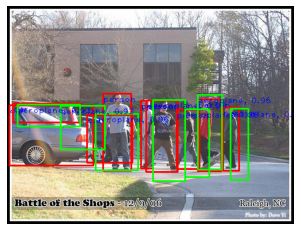

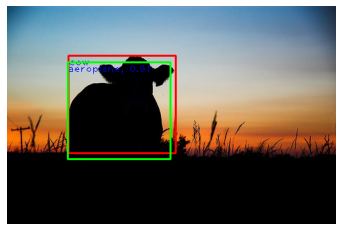

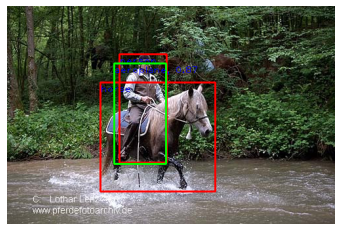

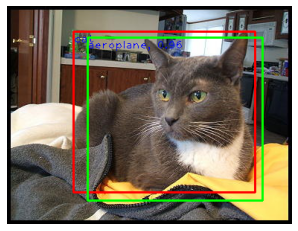

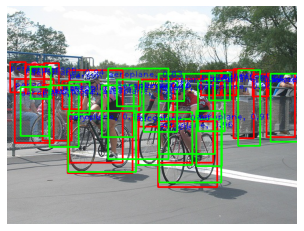

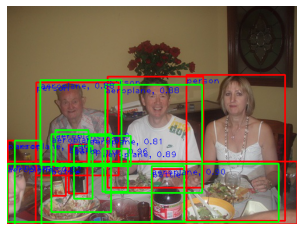

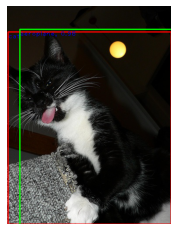

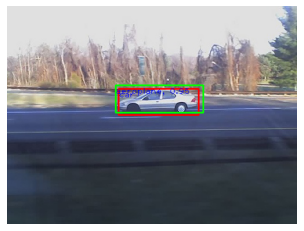

Total inference time: 1.3s


In [16]:
RPNInference(rpn, small_train_loader, small_dataset, idx_to_class, thresh=0.8, nms_thresh=0.3)

number of pos proposals :  50
(Iter 0 / 1)
(Epoch 0 / 200) loss: 44.2022 time per epoch: 0.1s
number of pos proposals :  50
(Iter 0 / 1)
(Epoch 1 / 200) loss: 61.6304 time per epoch: 0.2s
number of pos proposals :  50
(Iter 0 / 1)
(Epoch 2 / 200) loss: 41.9160 time per epoch: 0.2s
number of pos proposals :  50
(Iter 0 / 1)
(Epoch 3 / 200) loss: 34.2118 time per epoch: 0.2s
number of pos proposals :  50
(Iter 0 / 1)
(Epoch 4 / 200) loss: 32.1199 time per epoch: 0.2s
number of pos proposals :  50
(Iter 0 / 1)
(Epoch 5 / 200) loss: 30.2899 time per epoch: 0.1s
number of pos proposals :  50
(Iter 0 / 1)
(Epoch 6 / 200) loss: 29.1996 time per epoch: 0.1s
number of pos proposals :  50
(Iter 0 / 1)
(Epoch 7 / 200) loss: 27.5521 time per epoch: 0.1s
number of pos proposals :  50
(Iter 0 / 1)
(Epoch 8 / 200) loss: 26.3435 time per epoch: 0.1s
number of pos proposals :  50
(Iter 0 / 1)
(Epoch 9 / 200) loss: 25.3314 time per epoch: 0.1s
number of pos proposals :  50
(Iter 0 / 1)
(Epoch 10 / 200) 

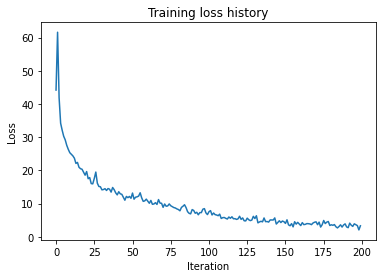

In [18]:
lr = 1e-3
detector = TwoStageDetector().to(dtype=torch.float32, device='cuda')
DetectionSolver(detector, small_train_loader, learning_rate=lr, num_epochs=200, dtype=torch.float32, device='cuda')

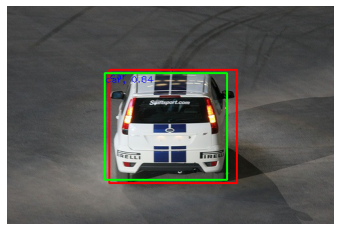

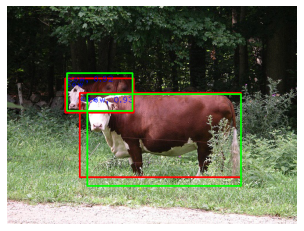

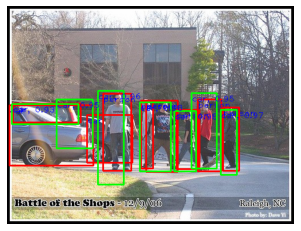

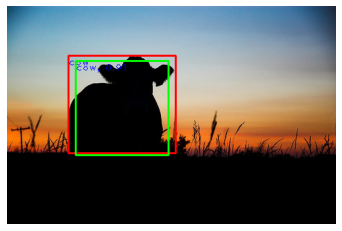

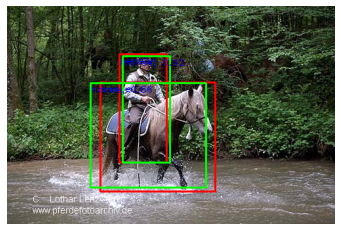

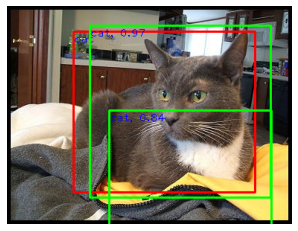

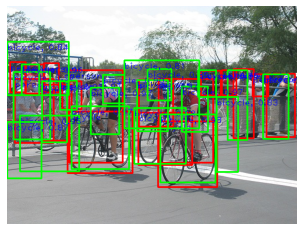

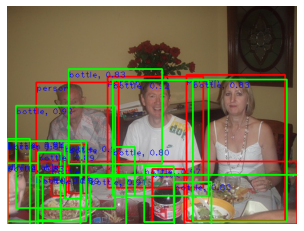

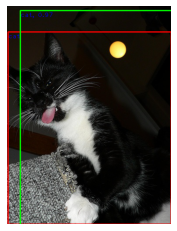

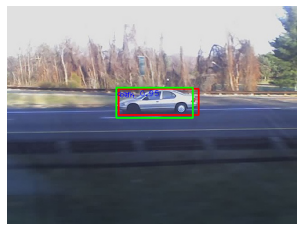

Total inference time: 1.3s


In [22]:
DetectionInference(detector, small_train_loader, small_dataset, idx_to_class, thresh=0.8, nms_thresh=0.3)

# Train whole data

number of pos proposals :  348
(Iter 0 / 25)
number of pos proposals :  410
(Iter 1 / 25)
number of pos proposals :  375
(Iter 2 / 25)
number of pos proposals :  362
(Iter 3 / 25)
number of pos proposals :  348
(Iter 4 / 25)
number of pos proposals :  316
(Iter 5 / 25)
number of pos proposals :  379
(Iter 6 / 25)
number of pos proposals :  362
(Iter 7 / 25)
number of pos proposals :  368
(Iter 8 / 25)
number of pos proposals :  363
(Iter 9 / 25)
number of pos proposals :  325
(Iter 10 / 25)
number of pos proposals :  355
(Iter 11 / 25)
number of pos proposals :  346
(Iter 12 / 25)
number of pos proposals :  363
(Iter 13 / 25)
number of pos proposals :  357
(Iter 14 / 25)
number of pos proposals :  349
(Iter 15 / 25)
number of pos proposals :  370
(Iter 16 / 25)
number of pos proposals :  367
(Iter 17 / 25)
number of pos proposals :  395
(Iter 18 / 25)
number of pos proposals :  386
(Iter 19 / 25)
number of pos proposals :  392
(Iter 20 / 25)
number of pos proposals :  405
(Iter 21 / 25

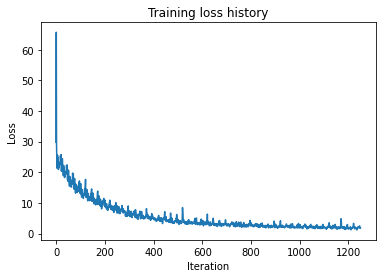

In [23]:
train_loader = pascal_voc2007_loader(train_dataset, batch_size=100) # a new loader

num_epochs = 50
lr = 5e-3
frcnn_detector = TwoStageDetector().to(dtype=torch.float32, device='cuda')
DetectionSolver(frcnn_detector, train_loader, learning_rate=lr, num_epochs=num_epochs, dtype=torch.float32, device='cuda')

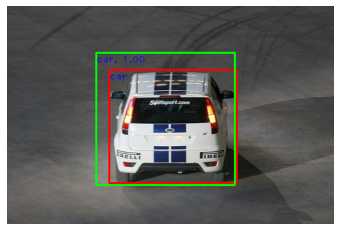

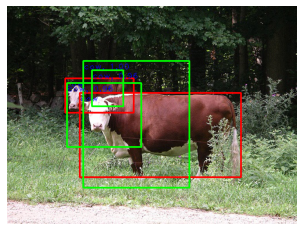

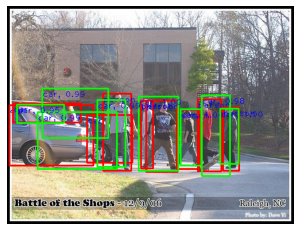

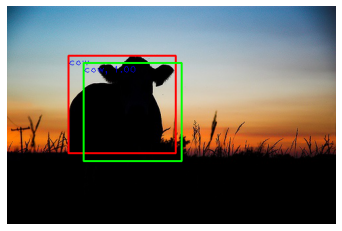

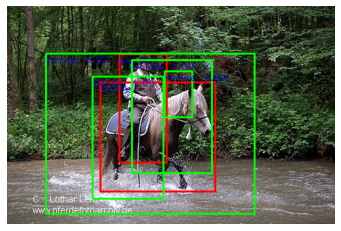

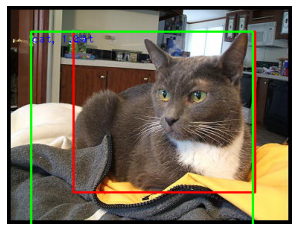

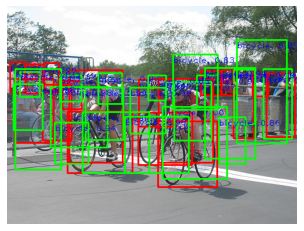

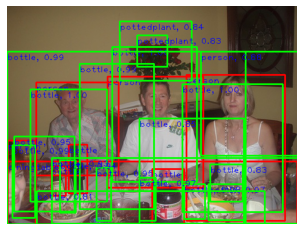

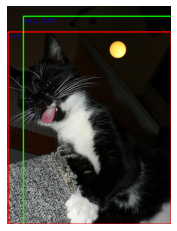

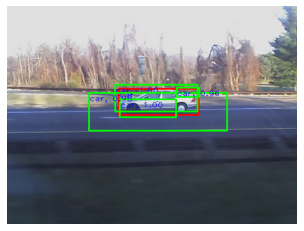

Total inference time: 1.2s


In [25]:
DetectionInference(frcnn_detector, small_train_loader, small_dataset, idx_to_class)